In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers

# Loading in the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Listing files in the 'test' folder
# folder_path = "/content/drive/My Drive/Break Through Tech AI @ MIT/Spring 2025 Kaggle Competition/KaggleSpring2025/test" # General path - modify as needed
folder_path = "/content/drive/My Drive/KaggleSpring2025/test" # General path - modify as needed
print(os.listdir(folder_path))

['6e620c3a29ad45715a16799d26589be3.jpg', '39f3448f33a429935cf1601f1585bd12.jpg', '3a99a5259471f5fee1d4db0d2067b413.jpg', '91c13b3c952550f97adc320b51b10557.jpg', '7a959183168ea039a889fc622afe2d41.jpg', '87cf70830aa7815e9daa81090235efd8.jpg', 'e38312ccf84a0e26adeebb4cb7f9732b.jpg', '8c3d26edb18555bbc6146f3581a66d82.jpg', '938528c2ba772fc83832aeca85171cf2.jpg', '3c8898cea81673fe523d75dc4a4c0d2d.jpg', 'f7e7fb15ba1bfabcf68bcd62528f76a8.jpg', 'b01a47a7fa02f5069b2c26634671664f.jpg', '4eff46ba9c97e429dc688f530a4e5fbc.jpg', 'e19700bdfef1034b79b79f1146d38bca.jpg', '7494f71845aa6663c050f6c029fd2f1d.jpg', '97bf4bfa2adc732f68b6445e9dd3ff28.jpg', '39b1853bbd7aee8beb2bd4be5bf0f922.jpg', '6c12f0e99a7af40789ae5aaf42946d84.jpg', '2aa5dac8b5f87535800796c039a818c8.jpg', '989def5053f967a52780018e95c65b09.jpg', '37566d4150bbc6080c2dd4ecc7ff9431.jpg', '794ba49ce953ec987bee17a700f84f00.jpg', '6fb6afb84ad3fadb641d9d5673156e93.jpg', '4abcc083990e6408c7936f204a913a81.jpg', 'a40fb61acc29b50d34decdd09e89e634.jpg',

In [ ]:
# List files in the 'train' folder
# folder_path2 = "/content/drive/My Drive/Break Through Tech AI @ MIT/Spring 2025 Kaggle Competition/KaggleSpring2025/train" # General path - modify as needed
folder_path2 = "/content/drive/My Drive/KaggleSpring2025/train" # General path - modify as needed
print(os.listdir(folder_path2))

['dyshidrotic-eczema', 'eczema', 'epidermal-nevus', 'acne', 'keloid', 'acne-vulgaris', 'melanoma', 'dermatomyositis', 'malignant-melanoma', 'basal-cell-carcinoma-morpheiform', 'mycosis-fungoides', 'folliculitis', 'squamous-cell-carcinoma', 'basal-cell-carcinoma', 'kaposi-sarcoma', 'actinic-keratosis', 'pyogenic-granuloma', 'seborrheic-keratosis', 'prurigo-nodularis', 'dermatofibroma', 'superficial-spreading-melanoma-ssm']


In [ ]:
# Loading in the train and test data
train_df = pd.read_csv('/content/drive/My Drive/KaggleSpring2025/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/KaggleSpring2025/test.csv')
# train_df = pd.read_csv('/content/drive/My Drive/Break Through Tech AI @ MIT/Spring 2025 Kaggle Competition/KaggleSpring2025/train.csv')
# test_df = pd.read_csv('/content/drive/My Drive/Break Through Tech AI @ MIT/Spring 2025 Kaggle Competition/KaggleSpring2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [ ]:
# example
print(len(os.listdir('/content/drive/My Drive/KaggleSpring2025/train/dyshidrotic-eczema')))
# print(len(os.listdir('/content/drive/My Drive/Break Through Tech AI @ MIT/Spring 2025 Kaggle Competition/KaggleSpring2025/train/dyshidrotic-eczema')))

23


In [ ]:
print(len(os.listdir('/content/drive/My Drive/KaggleSpring2025/test')))

1227


In [ ]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [ ]:
import tensorflow as tf
from tensorflow import keras


# Generating the dimensions (height, width) and channel (red, green, blue)
image_size = (180, 180)  # Target dimensions for resizing images (height, width).
batch_size = 32  # Number of images processed in a single batch during training.
# Note: A batch size of 128 (common in other setups) may exceed Colab's memory limits, causing crashes.
# The chosen batch size of 32 balances memory usage and runtime, with an estimated runtime of ~3 hours.

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    folder_path2,             # Path to the directory containing the dataset.
    validation_split=0.2,    # Specify that 20% of the dataset will be used for validation.
    subset="both",           # Create both training and validation datasets from the directory.
    seed=42,                 # Random seed to ensure reproducibility when shuffling the data.
    image_size=image_size,   # Resize all images to the specified dimensions (180x180).
    batch_size=batch_size,   # Divide the dataset into batches of the specified size (32 images per batch).
)

Found 27 files belonging to 21 classes.
Using 22 files for training.
Using 5 files for validation.


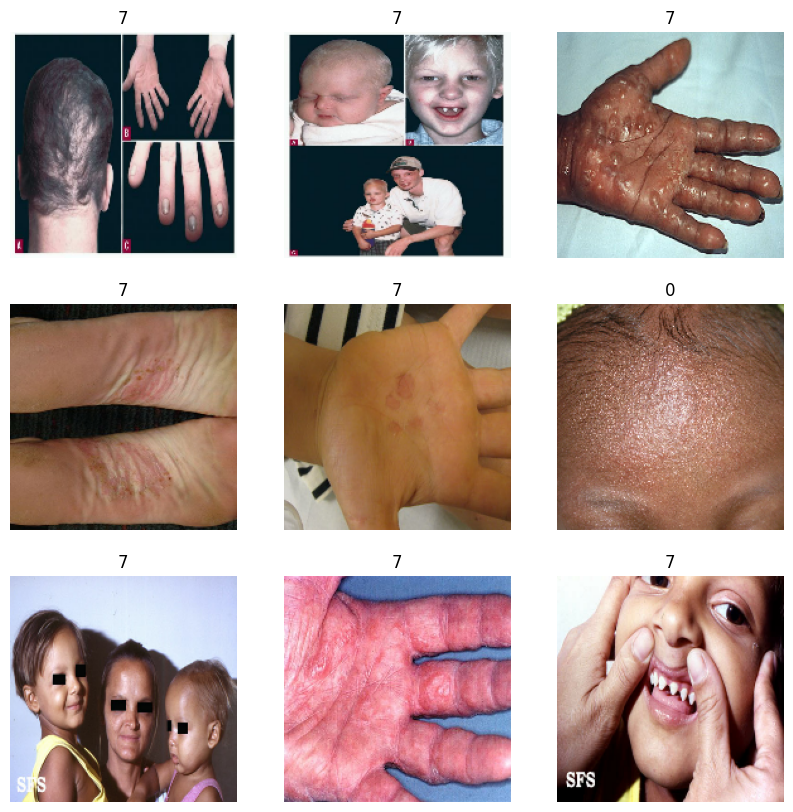

In [ ]:
# Visualizing the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Image Processing

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

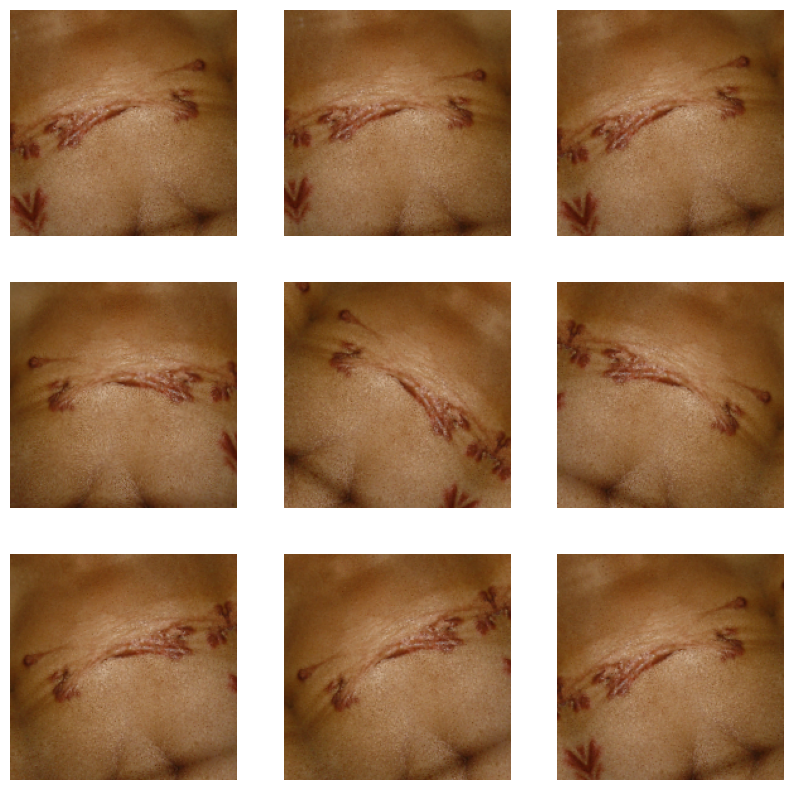

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [ ]:
from tensorflow import data as tf_data

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Model

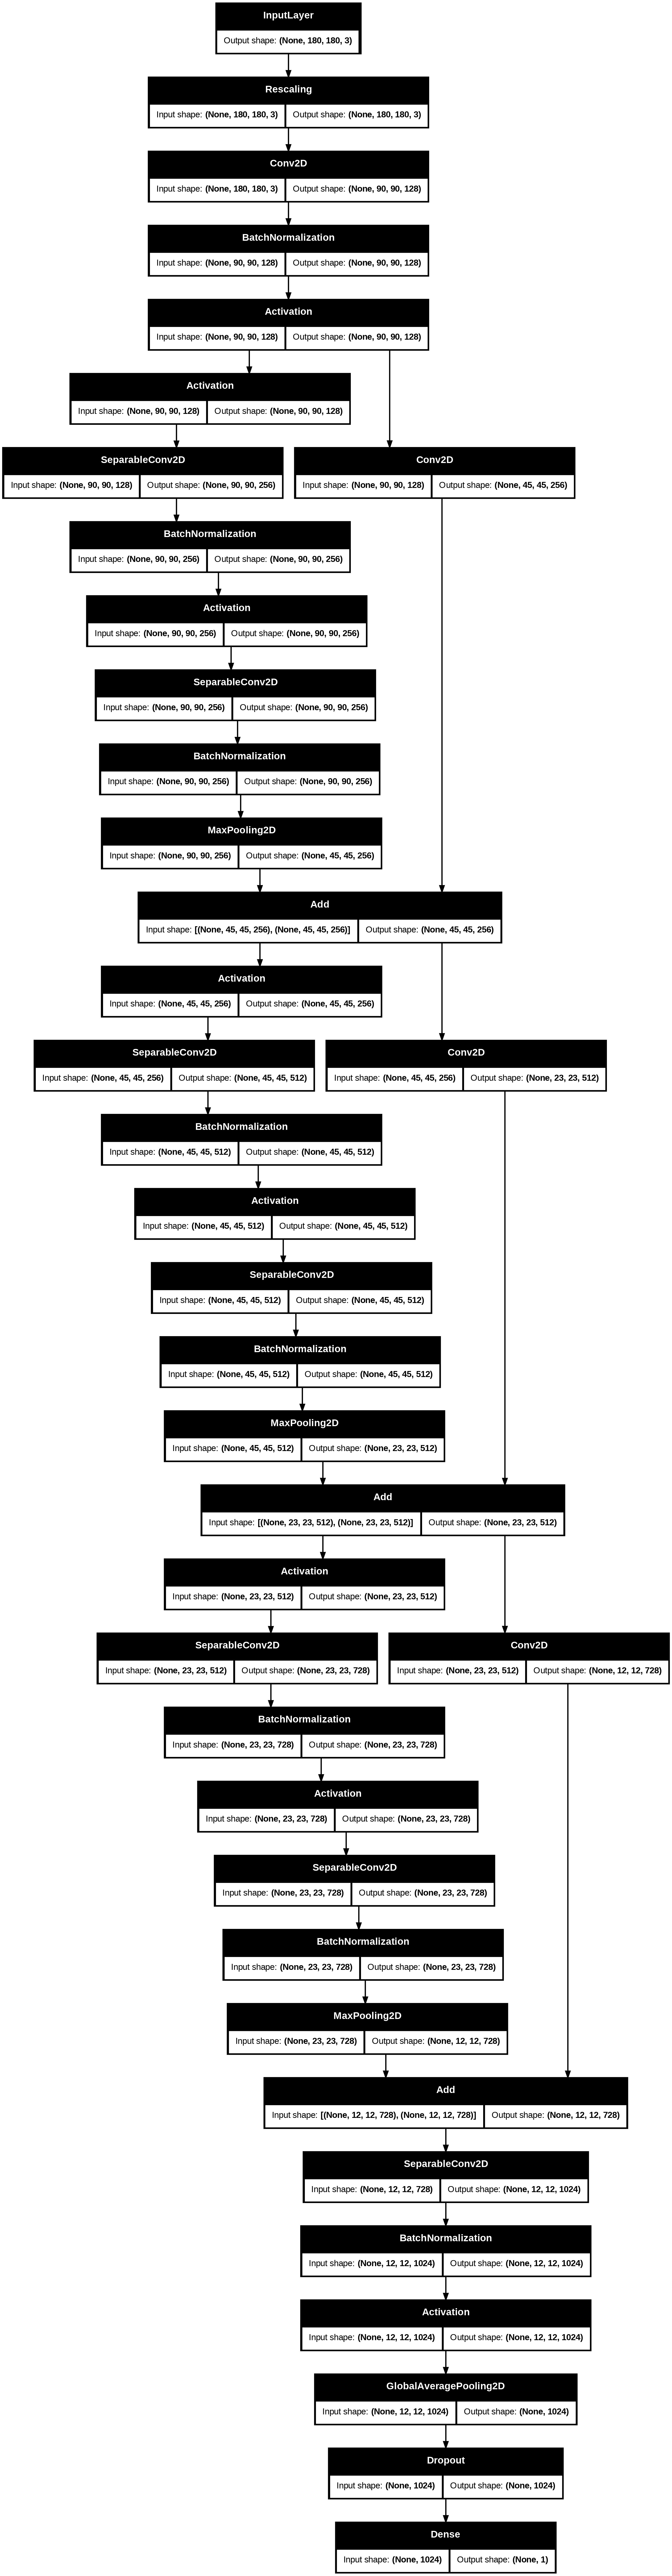

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Define the input layer with the specified shape.

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    # Rescale pixel values from [0, 255] to [0, 1] by dividing by 255 for normalization.

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    # Apply a convolutional layer with 128 filters, a 3x3 kernel, stride of 2, and "same" padding.
    # This reduces the spatial dimensions of the input image.

    x = layers.BatchNormalization()(x)
    # Normalize the activations from the previous layer to stabilize and accelerate training.

    x = layers.Activation("relu")(x)
    # Apply ReLU (Rectified Linear Unit) activation to introduce non-linearity.

    previous_block_activation = x
    # Save the output of the entry block for residual connections.

    for size in [256, 512, 728]:
        # Loop through a series of blocks with increasing filter sizes (256, 512, 728).

        x = layers.Activation("relu")(x)
        # Apply ReLU activation to the current block's input.

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # Apply a depthwise separable convolution with the specified number of filters and 3x3 kernel.

        x = layers.BatchNormalization()(x)
        # Normalize the activations after the convolution.

        x = layers.Activation("relu")(x)
        # Apply ReLU activation again.

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # Apply another depthwise separable convolution with the same filter size.

        x = layers.BatchNormalization()(x)
        # Normalize the activations again.

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # Apply a 3x3 max pooling layer with a stride of 2 to reduce the spatial dimensions.

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        # Apply a 1x1 convolution to the previous block's output to match dimensions for addition.

        x = layers.add([x, residual])
        # Add the residual connection to the current block's output.

        previous_block_activation = x
        # Update the residual reference for the next block.

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    # Apply a depthwise separable convolution with 1024 filters and 3x3 kernel.

    x = layers.BatchNormalization()(x)
    # Normalize the activations.

    x = layers.Activation("relu")(x)
    # Apply ReLU activation.

    x = layers.GlobalAveragePooling2D()(x)
    # Apply global average pooling to reduce each feature map to a single value.

    if num_classes == 2:
        units = 1
        # If it's a binary classification task, the output layer will have one unit.
    else:
        units = num_classes
        # For multi-class classification, the output layer will have one unit per class.

    x = layers.Dropout(0.25)(x)
    # Apply dropout with a rate of 25% to reduce overfitting.

    outputs = layers.Dense(units, activation=None)(x)
    # Define the output layer with `units` neurons. No activation is applied here (logits are returned).

    return keras.Model(inputs, outputs)
    # Create and return the Keras model.

# Create the model instance.
model = make_model(input_shape=image_size + (3,), num_classes=2)
# Call `make_model` with input shape (180, 180, 3) (for RGB images) and binary classification (2 classes).

keras.utils.plot_model(model, show_shapes=True)
# Visualize the model's architecture with layer shapes using Keras's plot_model utility.

# Train

In [ ]:
epochs = 12

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - acc: 0.0455 - loss: 4.2068 - val_acc: 0.0000e+00 - val_loss: 0.6640
Epoch 2/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - acc: 0.0455 - loss: 1.5794 - val_acc: 0.0000e+00 - val_loss: 0.6182
Epoch 3/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - acc: 0.0455 - loss: -0.8554 - val_acc: 0.0000e+00 - val_loss: 0.5712
Epoch 4/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - acc: 0.0000e+00 - loss: -3.6627 - val_acc: 0.0000e+00 - val_loss: 0.5237
Epoch 5/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - acc: 0.0000e+00 - loss: -5.9206 - val_acc: 0.0000e+00 - val_loss: 0.4756
Epoch 6/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - acc: 0.0455 - loss: -7.3588 - val_acc: 0.0000e+00 - val_loss: 0.4264
Epoch 7/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - acc: 0.0000e+00 - loss: -9.8154 - val_acc: 0.0000e+00 - val_loss: 0.3768
Epoch 8/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - acc: 0.0000e+00 - loss: -10.3205 - val_acc: 0.0000e+00 - val_loss: 0.3261
Epoch 9/12
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
This image is 47.76% yes and 52.24% no.


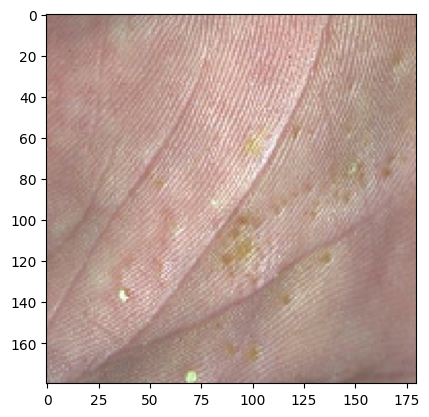

In [ ]:
img = keras.utils.load_img("/content/drive/My Drive/KaggleSpring2025/train/dyshidrotic-eczema/18eee27413f59dd3f25d8987e81ca91b.jpg", target_size=image_size) # general path

# img = keras.utils.load_img("/content/drive/MyDrive/Break Through Tech/KaggleSpring2025/train/dyshidrotic-eczema/18eee27413f59dd3f25d8987e81ca91b.jpg", target_size=image_size)
# img = keras.utils.load_img("/content/drive/My Drive/Break Through Tech AI @ MIT/Spring 2025 Kaggle Competition/KaggleSpring2025/train/dyshidrotic-eczema/18eee27413f59dd3f25d8987e81ca91b.jpg", target_size=image_size)

plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% yes and {100 * score:.2f}% no.")

In [ ]:


# Assuming `model` is already trained
# Load the test dataset (assumed to be the same as your train data)
test_df = pd.read_csv('/content/drive/My Drive/KaggleSpring2025/test.csv')

# Set the image size that the model expects
image_size = (180, 180)  # Same as your model input size

# Create a list to hold the results
predictions_list = []

# Iterate over the test DataFrame
for idx, row in test_df.iterrows():
    # Extract the MD5 hash (filename)
    md5hash = row['md5hash'] # Ensure the correct file extension is added

    # Get the image path based on the MD5 hash (assuming images are in the test folder)
    img_path = os.path.join("/content/drive/My Drive/KaggleSpring2025/test", md5hash)

    # Load and preprocess the image
    img = keras.utils.load_img(img_path, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_array)
    score = float(keras.activations.sigmoid(predictions[0][0]))  # Get the predicted score

    # Determine the predicted label (0 or 1)
    predicted_label = 0 if score < 0.5 else 1

    # Append the md5hash and label to the results list
    predictions_list.append([md5hash, predicted_label])

# Create a DataFrame from the results
predictions_df = pd.DataFrame(predictions_list, columns=["md5hash", "label"])

# Save the DataFrame to a CSV file
predictions_df.to_csv('/content/drive/My Drive/KaggleSpring2025/predictions.csv', index=False)

# Check the first few rows to confirm it worked
print(predictions_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 